# Virtual ADC example
---


## Load the bitstream into the Programmable Logic

In [37]:
%reload_ext autoreload
%autoreload 2
# Import the X-HEEP Python class
from pynq import x_heep
# Allow the import of all modules in this directory
import sys
import os

SDK_PATH = "/home/xilinx/x-heep-femu-sdk/"
RISCV_PATH = 'sw/riscv/'
APP_PATH = SDK_PATH + RISCV_PATH + 'apps/adc-emu/'
ADC_BIN_NAME = 'adc_in'

sys.path.append(SDK_PATH + "sw/arm/apps/adc-emu/src")

from timeseries import *
from report import *

# Load the X-HEEP bitstream
xh = x_heep()

## Generate an input array to use as signal 

In [38]:
import numpy as np
from timeseries import Timeseries

MAX_POSSIBLE_DATA_LENGTH    = 2048
INPUT_DATA_LENGTH           = 800

# Generate a binary file from a txt
if 0:
    with open( APP_PATH + 'EpiPhone.txt', 'r') as f: 
        din = f.readlines()

    # Keep only the first few values
    din_f = din[:INPUT_DATA_LENGTH]
    din_f = np.array(din_f, dtype=float)

    # Don't normalize, just round to u16
    din_u16 = din_f.astype(np.uint16)

    # Save the array to a binary file
    din_norm_u32 = din_u16.astype(np.uint32).copy()
    with open(APP_PATH + ADC_BIN_NAME + "bin",'wb') as file:
        din_norm_u32.byteswap(True).tofile(file)


# Take a pre-generated binary file
if 1: 
    src         = SDK_PATH + 'sw/arm/apps/adc-emu/out/'
    src_name    = 'Raw_Norm'
    ext_bin     = '.bin'
    ext_pkl     = '.pkl'
    dst         = APP_PATH
    dst_name    = ADC_BIN_NAME

    din = Timeseries.load(src+src_name+ext_pkl)
    din.data += abs(min(din.data))
    din.export_bin(path=APP_PATH, name=ADC_BIN_NAME)

    INPUT_DATA_LENGTH = len(din.data)



## Compile the code and run the application
You can change the variable `SKIP_COMPILE`  to 1 to avoid compiling each time.

You can change the variable `SKIP_MEMORY`   to 1 to avoid generating the ADC memory each time.

You can change the variable `VERBOSE`       to 0 to supress the live printing of the UART.

In [39]:
# Skip compiling if all you want to do is run the application
# Note that the compilation is affected by the parameters written to the definitions.h file
SKIP_COMPILE    = 0
# Skip the memory generation
SKIP_MEMORY     = 0
# Wether to see the X-HEEP UART output live.
VERBOSE         = 0
# Enable the printfs inside X-HEEP application. This is not the same as VERBOSE, as it actually reflects in C-code and therefore in performance.
ENABLE_PRINTF   = 1



# Write the definitions header file to share information with the C code
defs = APP_PATH + 'definitions.h'
xh.open_definitions (defs, "DEFINITIONS")
xh.add_definition   (defs, "INPUT_DATA_LENGTH", INPUT_DATA_LENGTH)
xh.add_definition   (defs, "ENABLE_PRINTF",     ENABLE_PRINTF)
xh.close_definitions (defs)


# Compile the application
if SKIP_COMPILE or xh.compile_app("adc-emu"):

    if not SKIP_MEMORY:
        # Write the ADC data to the virtual ADC
        adc = xh.init_adc_mem() # Init the ADC memory
        xh.reset_adc_mem(adc)   # Reset the ADC memory
        xh.write_adc_mem(adc)   # Write the ADC memory

    t, sf = xh.thread_start(VERBOSE)   # Start a background thread that reads from the UART

    perf_cnt = xh.init_perf_cnt()       # Init the performance counters
    xh.reset_perf_cnt(perf_cnt)         # Reset the performance counters
    xh.start_perf_cnt_manual(perf_cnt)  # Start the performance counters

    out, _ = xh.run_app()               # Run the application (disregarding the error output)

    xh.stop_perf_cnt(perf_cnt)          # Stop the performance counters

    xh.thread_stop(t, sf)               # Stop the background thread that reads from the UART

✅ Compile SUCCESS
✅ Return SUCCESS
 


### Parse the UART output

In [40]:
app_out = xh.uart_data

# Find positions of strings starting with "#"
starts = [i for i, s in enumerate(app_out) if s.startswith("# ")]
# Find positions of strings starting with "#"
ends = [i for i, s in enumerate(app_out) if s.startswith("#---")]

# Sanity check to make sure that all output lists are closed
if len(starts) != len(ends): sys.exit("❌ Invalid output")




# Parsing the list into two separate lists
cols = []
for i in range(2):
    cols.append([int(item.split(' | ')[i].strip() ) for item in xh.uart_data])

lpfd = Timeseries("LPFd")
hpfd = Timeseries("HPFd")

lpfd.data = cols[0]
hpfd.data = cols[1]


## Plot the input and output

Text(0.5, 1.0, 'EEG signal from EpiPhone')

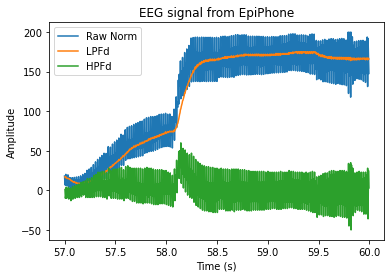

In [41]:
import matplotlib.pyplot as plt

plt.plot(din.time, din.data)
plt.plot(din.time[1:], lpfd.data)
plt.plot(din.time[1:], hpfd.data)

plt.legend([ din.name, lpfd.name, hpfd.name])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("EEG signal from EpiPhone")

## Performance and Energy

This will generate a report in `sw/riscv/build/energy_estim.csv`. 

Run the `estim.ipynb` notebook to visualize the results. 

Total cycles: 	0.42 s
Total energy: 	307.45 µJ
Avg power:	737.95 µW
---------------------
❌ Power FAIL
✅ Latency SUCCESS


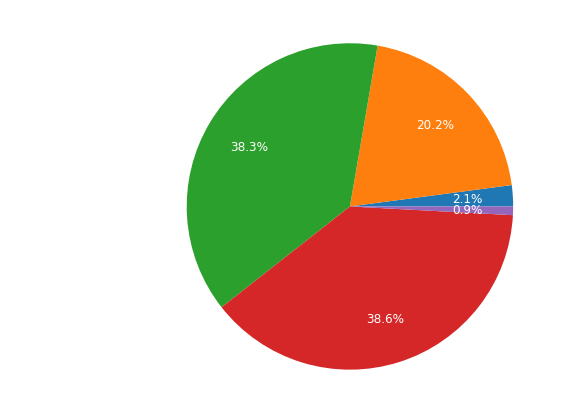

In [42]:
# Define some budgets that we should not cross
POWER_BUDGET_W      = 100e-6
LATENCY_BUDGET_S    = 1

xh.read_perf_cnt(perf_cnt);         # Read the performance counters
xh.estimate_performance(False);     # Estimate the performance 
xh.estimate_energy("HVT", False);   # Estimate the energy

rep_summary, rep_latency, rep_energy  = report() # Get the report

print("---------------------")
if rep_summary['Power_W']   < POWER_BUDGET_W:   print("✅ Power SUCCESS")   
else: print("❌ Power FAIL")
if rep_summary['Latency_s'] < LATENCY_BUDGET_S: print("✅ Latency SUCCESS") 
else: print("❌ Latency FAIL")

# Plot a breakdown of the energy consumption
plot_energy( rep_energy, level=1 )

# In case you want to print the dictionaries containing the breakdown
if 0:
    import pprint
    pprint.pprint(rep_energy)
